## Data Collection

In [1]:
import praw
import pandas as pd

# Reddit API authentication
reddit = praw.Reddit(
    client_id="pzesY9KJ5dirnPGFkQ6QFA",
    client_secret="cKHT4uAr-lWdMj4efLhIe6mHXLBh5g",
    user_agent="trend analysis"
)

# Collect posts
posts = []
for submission in reddit.subreddit("technology").hot(limit=400):
    posts.append({
        "title": submission.title,
        "text": submission.selftext
    })

df = pd.DataFrame(posts)
df.to_csv("reddit_posts.csv", index=False)
df.head()


,title,text
0,Russia Is Pumping Out Disinformation That Look...,
1,SpaceX Gets Billions From the Government. It G...,
2,US Energy Secretary Calls For An End To All Su...,
3,Report: Microsoft's latest Windows 11 24H2 upd...,
4,"Versant to rename MSNBC, drop famed peacock lo...",


In [2]:
df.shape

(400, 2)

## Data Cleaning

In [3]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

df = pd.read_csv("reddit_posts.csv")
df["text"] = (df["title"].fillna('') + " " + df["text"].fillna(''))

# Clean text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.to_csv("cleaned_posts.csv", index=False)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atusi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,text,clean_text
0,Russia Is Pumping Out Disinformation That Look...,Russia Is Pumping Out Disinformation That Look...,russia pumping disinformation looks like legit...
1,SpaceX Gets Billions From the Government. It G...,SpaceX Gets Billions From the Government. It G...,spacex gets billions government gives little n...
2,US Energy Secretary Calls For An End To All Su...,US Energy Secretary Calls For An End To All Su...,us energy secretary calls end subsidies solar ...
3,Report: Microsoft's latest Windows 11 24H2 upd...,Report: Microsoft's latest Windows 11 24H2 upd...,report microsofts latest windows h update brea...
4,"Versant to rename MSNBC, drop famed peacock lo...","Versant to rename MSNBC, drop famed peacock lo...",versant rename msnbc drop famed peacock logos ...


## Clustering Analysis

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

df = pd.read_csv("cleaned_posts.csv")

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])

kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

df[["clean_text", "cluster"]].head()
df.to_csv("clustered_posts.csv", index=False)

In [5]:
df = pd.read_csv("clustered_posts.csv")
df['cluster'].unique()


array([1, 0, 2, 4, 3])

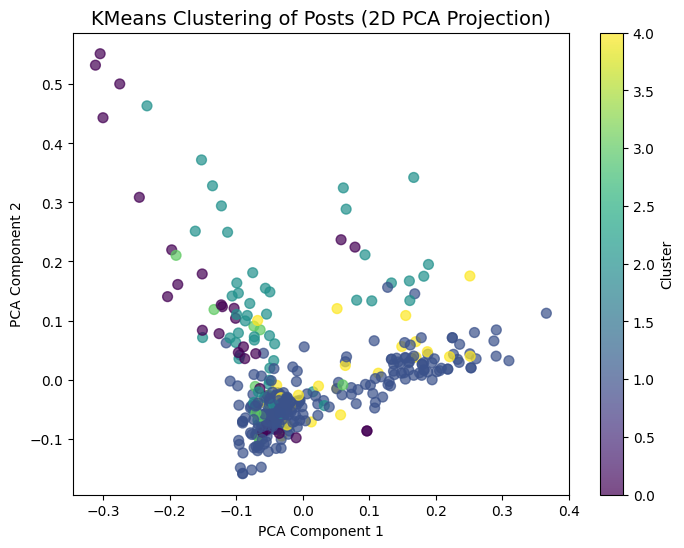

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce TF-IDF features to 2D using PCA
pca = PCA(n_components=2, random_state=42)
reduced_X = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["cluster"], cmap='viridis', s=50, alpha=0.7)

# Labeling
plt.title("KMeans Clustering of Posts (2D PCA Projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


## Classification Model

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df = pd.read_csv("clustered_posts.csv")

df["trending"] = df["cluster"].apply(lambda x: 1 if x in [0,1] else 0)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["trending"]

# Handle imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))



Train Accuracy: 0.9959016393442623
Test Accuracy: 0.9754098360655737


## Random Forest Algorithm

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("clustered_posts.csv")

# Create target variable
df["trending"] = df["cluster"].apply(lambda x: 1 if x in [0,1] else 0)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["trending"]

# Handle imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

# Random Forest Model
model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees expand fully
    random_state=42,
    n_jobs=-1               # use all CPU cores for speed
)
model.fit(X_train, y_train)

# Accuracy
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))


Train Accuracy: 1.0
Test Accuracy: 0.9754098360655737
